---
title: "Desafio Final - AIChE Maringá"
author: "Gustavo J. V. Meira Filho"
format:
    pdf:
        documentclass: scrreprt
        pdf-engine: xelatex
        toc: true
        toc-depth: 3
        include-in-header: 
            text: |
                \usepackage[a4paper,margin=2.5cm]{geometry}
        execute:
            echo: true     
            warning: false   
            message: false 
execute:
    fig-format: png       
jupyter: AIChE-Internal-Challenges
---

# Bibliotecas

In [ ]:
import pandas as pd
import numpy as np

from graphmodex import plotlymodex
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import matplotlib.pyplot as plt
import seaborn as sns

pio.renderers.default = "png"

\newpage

# **Modelo**

A gente sempre começa estabelecendo um modelo para nosso problema, além de analisar as vartiáveis envolvidas e suas relações! 

In [7]:
df = pd.read_excel(r'..\data\base_desafio_regressao.xlsx')
del df['T2']

Podemos começar a nossa investigação com um gráfico pairwise (mas não é necessário)

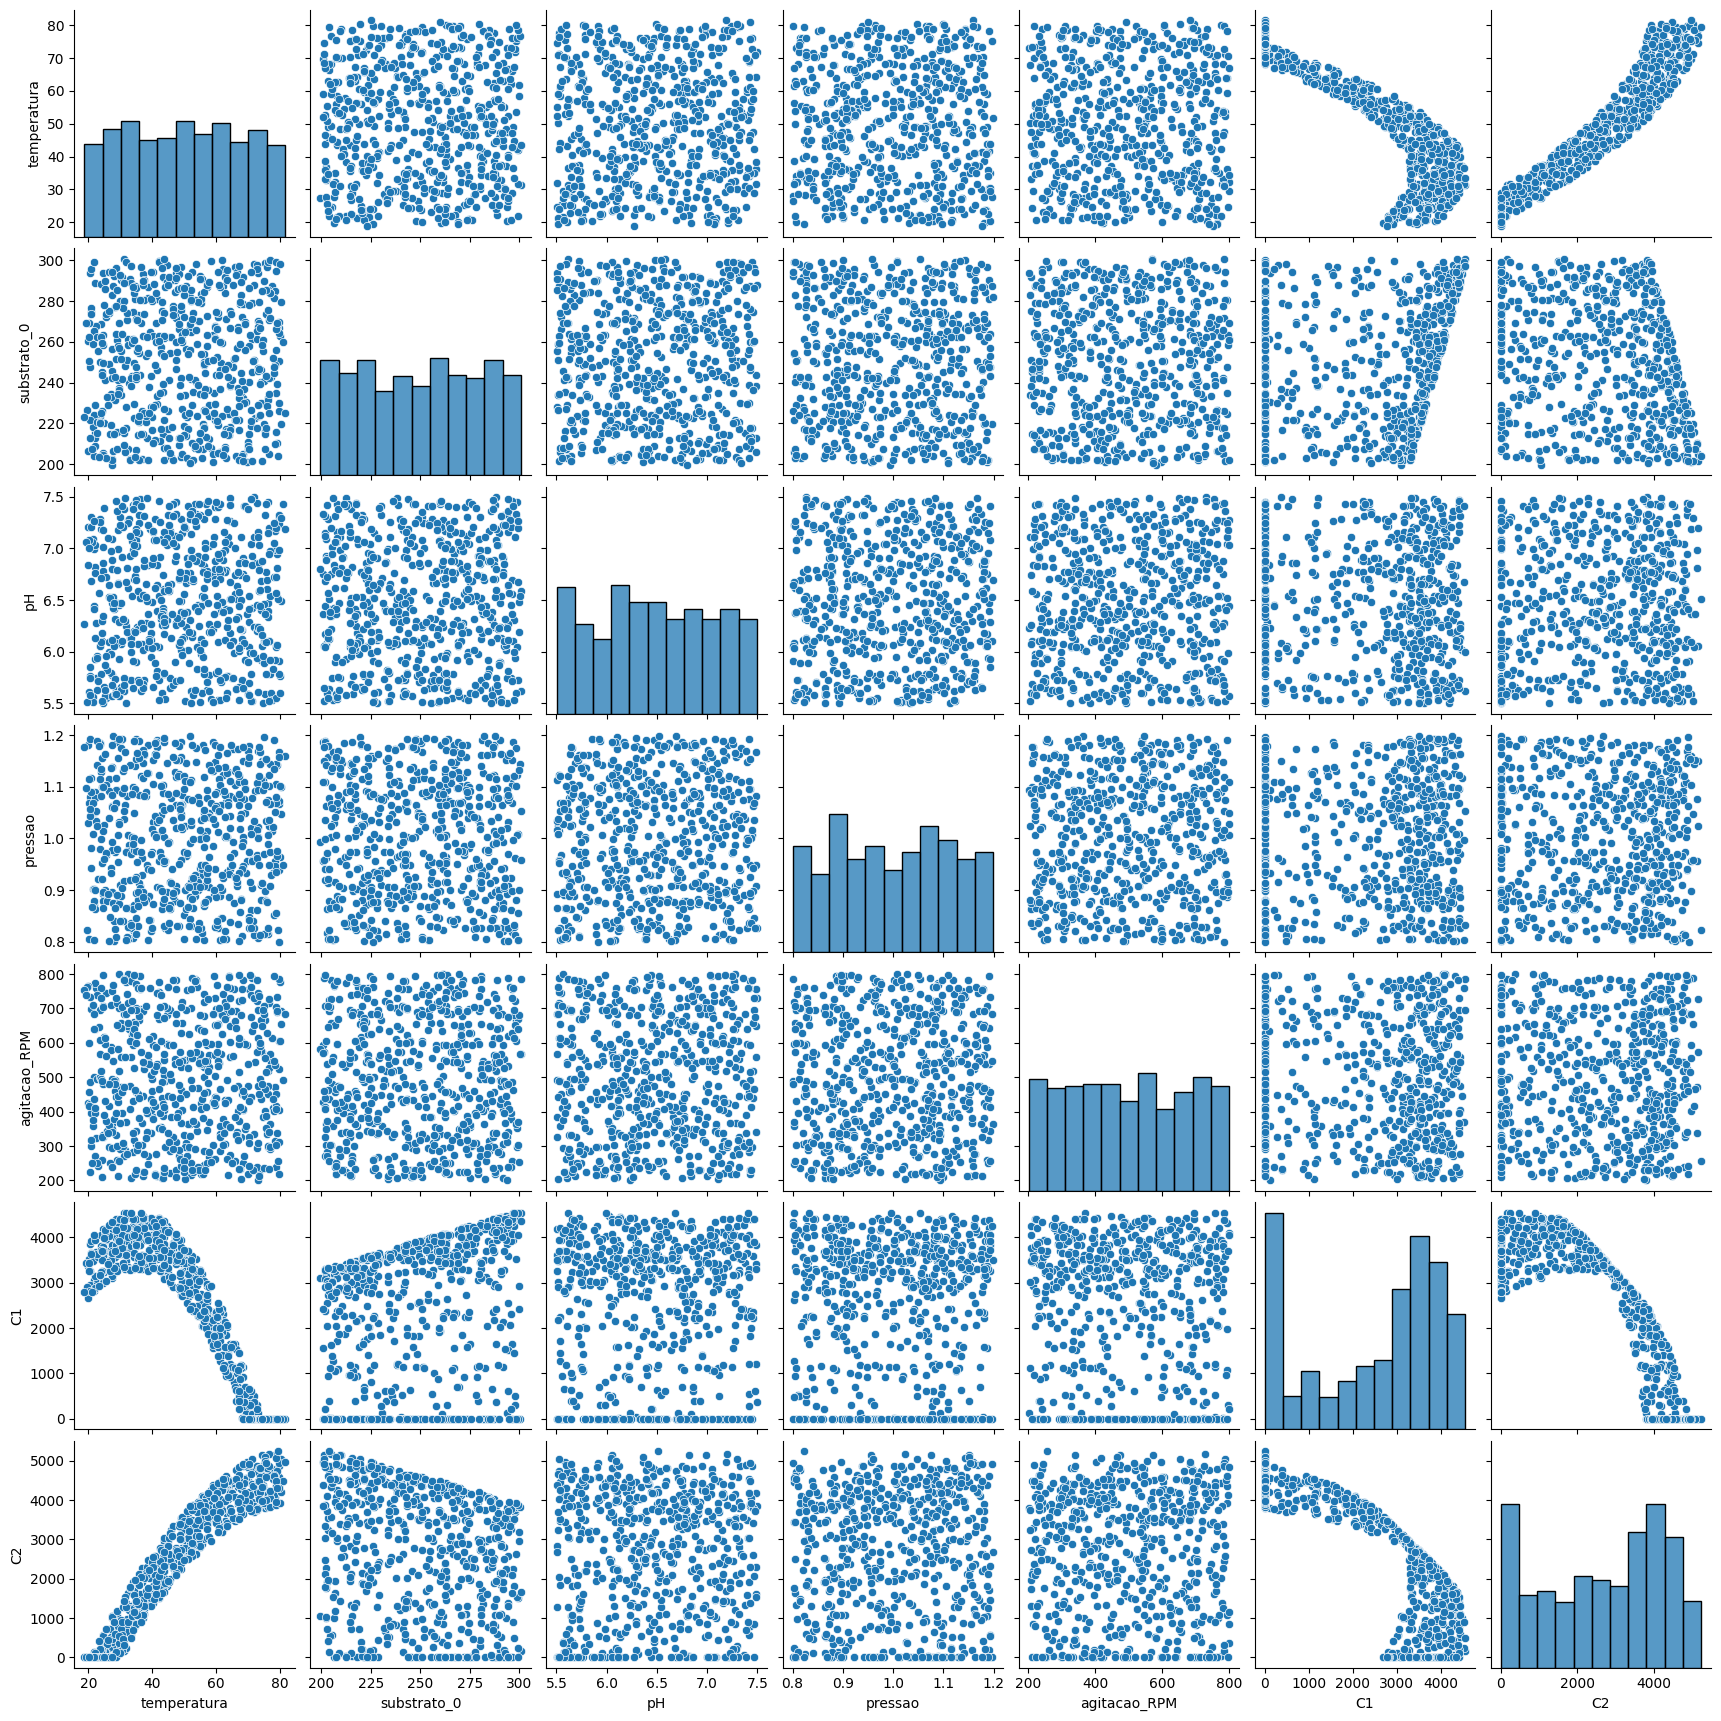

In [8]:
sns.pairplot(df);

Vou reutilizar esse código de um dos grupos do desafio, para abranger todas variáveis e usar a mesma lógica que o pessoal está usando. Mas isso não é necessário, podemos simplesmente plotar C1 e C2 contra as variáveis em um gráfico normal que já funcionaria.

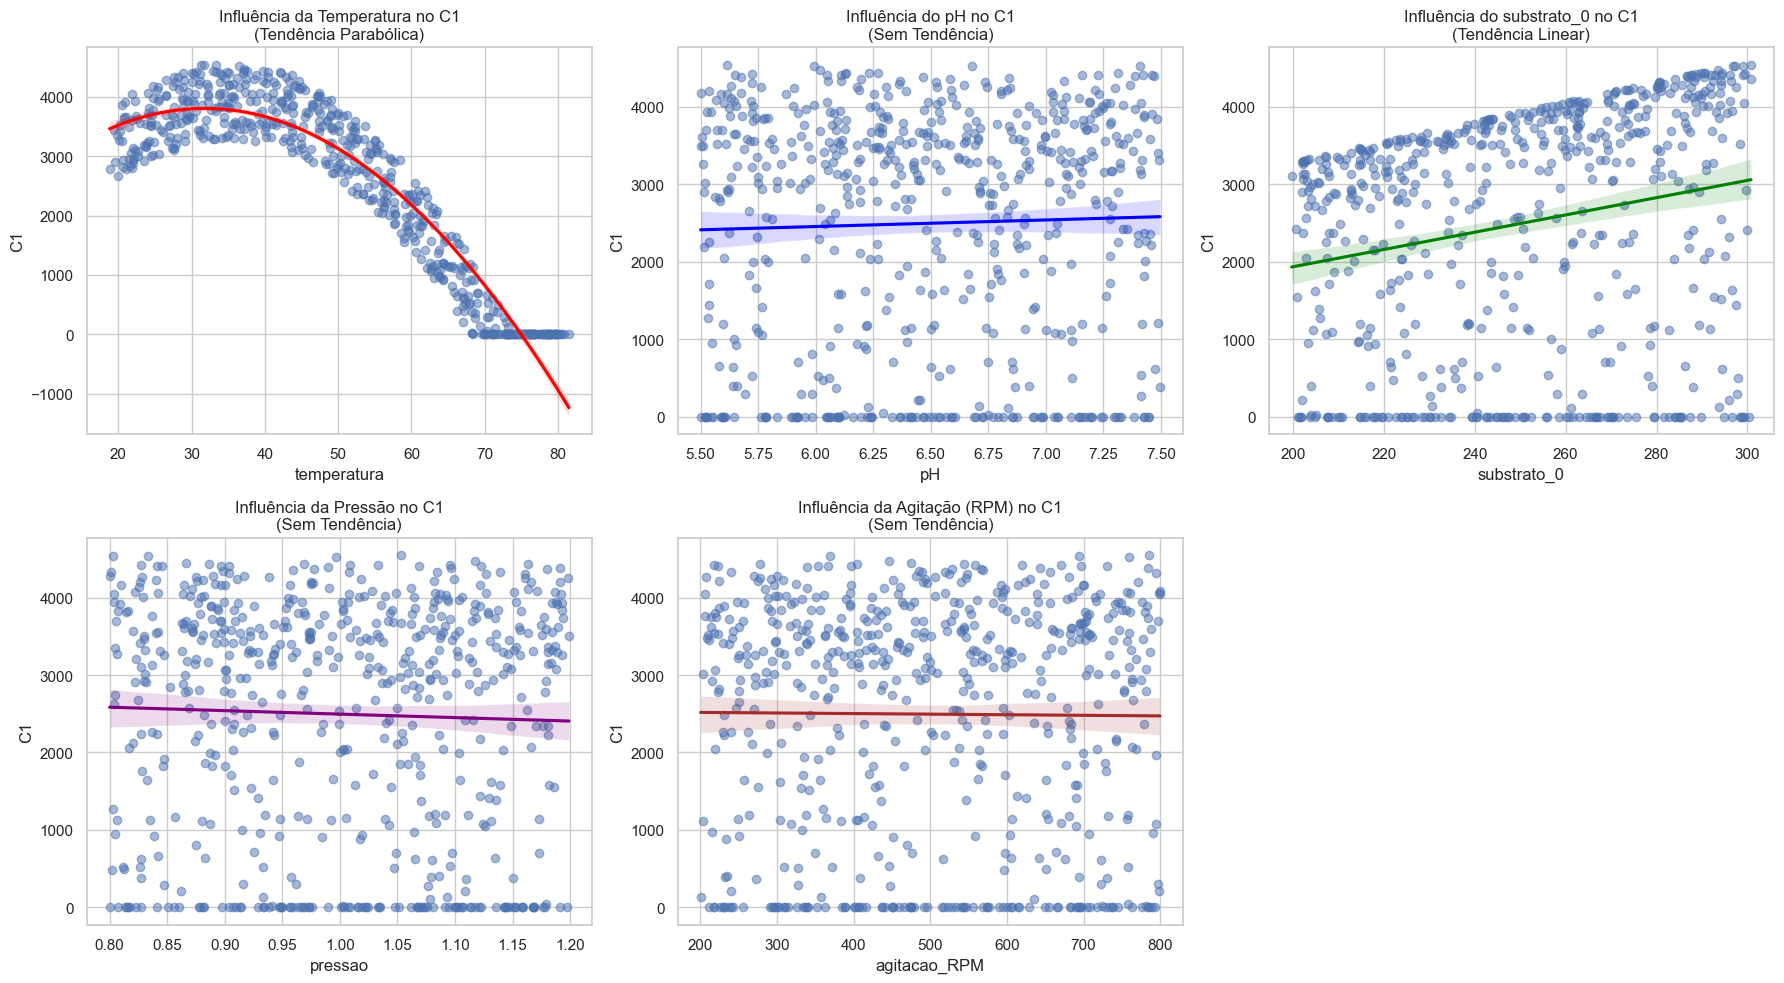

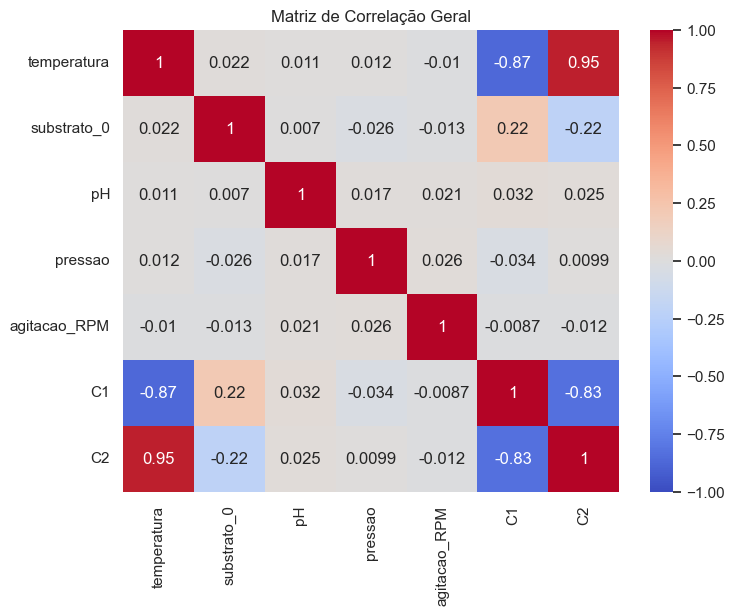

In [32]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Gráfico 1: Temperatura ---
sns.regplot(ax=axes[0, 0], x='temperatura', y='C1', data=df, order=2,
            scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
axes[0, 0].set_title('Influência da Temperatura no C1\n(Tendência Parabólica)')

# --- Gráfico 2: pH ---
sns.regplot(ax=axes[0, 1], x='pH', y='C1', data=df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'blue'})
axes[0, 1].set_title('Influência do pH no C1\n(Sem Tendência)')

# --- Gráfico 3: substrato_0 ---
sns.regplot(ax=axes[0, 2], x='substrato_0', y='C1', data=df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'green'})
axes[0, 2].set_title('Influência do substrato_0 no C1\n(Tendência Linear)')

# --- Gráfico 4: Pressão ---
sns.regplot(ax=axes[1, 0], x='pressao', y='C1', data=df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'purple'})
axes[1, 0].set_title('Influência da Pressão no C1\n(Sem Tendência)')

# --- Gráfico 5: Agitação ---
sns.regplot(ax=axes[1, 1], x='agitacao_RPM', y='C1', data=df,
            scatter_kws={'alpha':0.5}, line_kws={'color':'brown'})
axes[1, 1].set_title('Influência da Agitação (RPM) no C1\n(Sem Tendência)')

# --- Espaço vazio no subplot (pode remover ou usar para outro gráfico) ---
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# --- Heatmap de Correlação ---
correlacao = df.corr()
plt.figure(figsize=(8, 6))

sns.heatmap(correlacao, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Matriz de Correlação Geral")
plt.show()

A partir daqui fica claro que existe uma correlação quadrática de C1 e C2 com a temperatura - que é extremamente forte, inclusive, e que também uma leve correlação linear com a vazão de substrato no reator! Além disso, torna-se óbvio que a influência do pH, pressão e agitação são completamente aleatórios para o nosso sistema.

Dessa forma, nosso modelo final fica:
$$
C1 = (\alpha \cdot T^2) + (\beta \cdot T) + (\gamma \cdot S_0) + \delta
$$
$$
C2 = (\alpha \cdot T^2) + (\beta \cdot T) + (\gamma \cdot S_0) + \delta
$$

Como a temperatura tem mais influência e a nossa visualização é 2D, vou plotar C1 e C2 contra T para ficar mais fácil de visualizar a correlação.

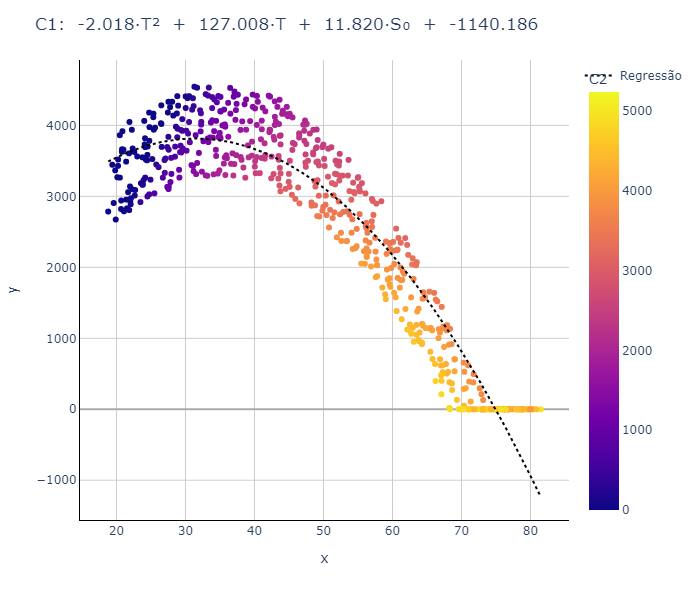

In [15]:
def regressao_(
    df, 
    x_quad='temperatura',       # variável que entra com termo quadrático
    x_lin='substrato_0',        # variável linear
    y='C1',                     # variável alvo
    color=None, 
    plot=True,
    return_y_pred=False
):
    # --------------------------
    # Montagem da matriz X
    # --------------------------
    X1 = df[x_quad].values               # temperatura
    X2 = df[x_lin].values                # substrato
    n  = len(df)

    # Modelo: y = a*T^2 + b*T + c*S0 + d
    X = np.vstack([X1**2, X1, X2, np.ones(n)]).T

    y_ = df[y].values

    # --------------------------
    # Solução analítica (Normal Equation)
    # --------------------------
    theta = np.linalg.inv(X.T @ X) @ X.T @ y_
    a, b, c, d = theta

    # --------------------------
    # Plotagem opcional
    # --------------------------
    if plot:
        fig = px.scatter(df, x=x_quad, y=y, color=color)

        x_reg = np.linspace(df[x_quad].min(), df[x_quad].max(), 200)
        y_reg = a*x_reg**2 + b*x_reg + c*np.mean(df[x_lin]) + d

        fig.add_trace(go.Scatter(
            x=x_reg,
            y=y_reg,
            mode='lines',
            line=dict(color='black', dash='dot'),
            name='Regressão'
        ))

        plotlymodex.main_layout(fig,
            title=f"{y}:  {a:.3f}·T²  +  {b:.3f}·T  +  {c:.3f}·S₀  +  {d:.3f}"
        )

        fig.show()

    # --------------------------
    # Retornar predição opcional
    # --------------------------
    if return_y_pred:
        return a*X1**2 + b*X1 + c*X2 + d

    # --------------------------
    # Retorna os coeficientes
    # --------------------------
    return dict(
        a=a, b=b, c=c, d=d,
        formula=f"{a:.4f}·T² + {b:.4f}·T + {c:.4f}·S₀ + {d:.4f}"
    )

regressao_(df, y='C1', color='C2');

Uma sacada importante para um engenheiro, é entender que a partir de $\approx 75 \text{°C}$ já não existe organismos vivos, então posso tirar todos eles da minha regressão, para obter um ajuste melhor!

Ps.: Coloquei a cor dos gráficos como sendo o substrato para deixar o gráfico mais "3D". Aqui, vemos que para cada temperatura (eixo x) fixa de C1, o valor do substrato aumenta linearmente, por isso a influência do substrato é positiva. Para C2, o inverso ocorre: a cada valor do eixo x (temperatura) a concentração diminui com o substrato.

In [44]:
theta_C1 = regressao_(df.query("temperatura <= 75"), y='C1', plot=False)
theta_C1 = [theta_C1['a'], theta_C1['b'], theta_C1['c'], theta_C1['d']]

theta_C2 = regressao_(df.query("temperatura <= 75"), y='C2', plot=False)
theta_C2 = [theta_C2['a'], theta_C2['b'], theta_C2['c'], theta_C2['d']]

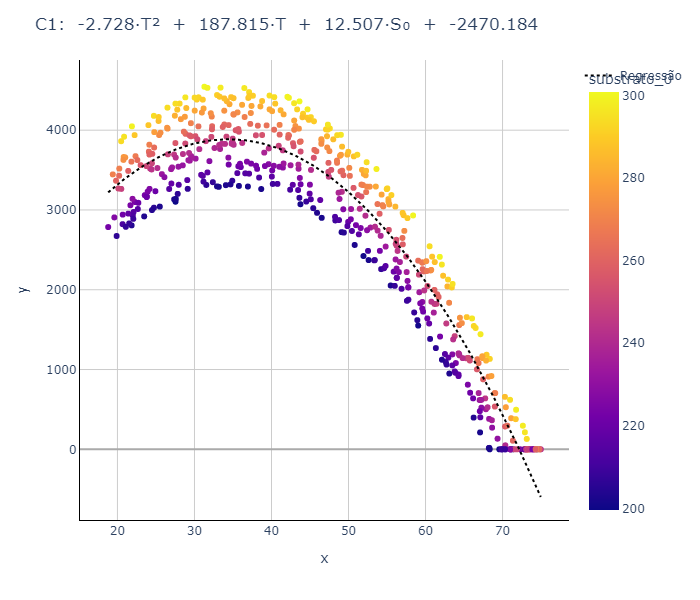

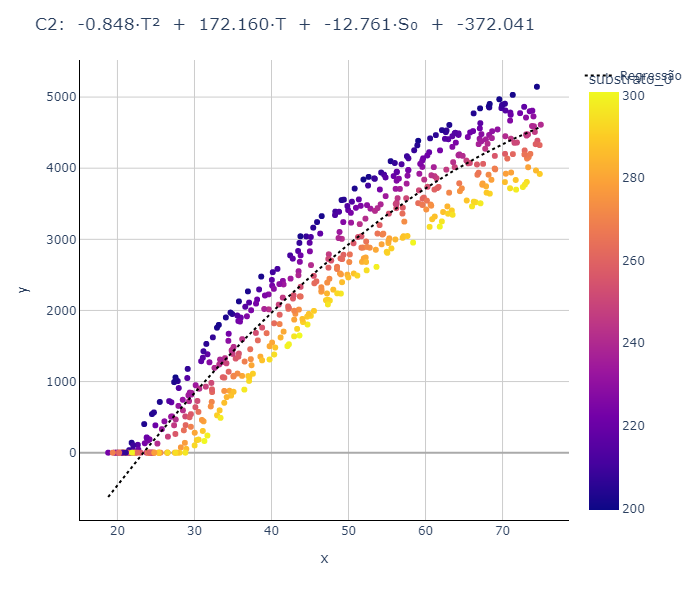

In [39]:
regressao_(df.query("temperatura <= 75"), y='C1', color='substrato_0');
regressao_(df.query("temperatura <= 75"), y='C2', color='substrato_0');

Pronto, já temos um modelo tanto para C1 quanto para C2. Agora podemos partir para as respostas.

\newpage

# **Exercício 1**

Considere que o potencial hidrogeniônico (pH) dentro do reator seja neutro, isto é, numericamente igual à 7, temperatura igual à 95,18 graus Celsius, pressão próxima de 1,51 atm, agitação com valor de 548,3 RPM e quantidade de substrato inicial igual à 360. Diante dessas informações fornecidas sobre as variáveis (ou não) dentro do reator bioquímico, qual será a concentração dos microrganismos 1 e 2 (C1 e C2)? 

Para esse exercício, podemos simplesmente colocar no nosso modelo e ver o resultado!

Como só temperatura e substrato têm influência, podemos ignorar as outras variáveis.

In [56]:
condicoes = np.array([95.18**2, 95.18, 360, 1])

print(f"""
C1: {condicoes @ theta_C1 :.2f}
C2: {condicoes @ theta_C2 :.2f}
""")


C1: -4806.44
C2: 3741.11



Isso deixa claro que não há organismos vivos da célula 1 nessas condições, e há uma quantidade quase que no auge desses organismos em C2 (podemos visualizar esse resultado nos gráficos do modelo para ver que o resultado está coerente). Isso ocorre pois a temperatura é muito alta (de forma que C1 já está morto mas C2 está no auge de seu desenvolvimento).

Aqui, é importante notar que essa temperatura está em uma região muito acima das observadas (que chegam até 75°C), de forma que esse comportamento parabólico de C2 pode não ser igual em 95°C. Mesmo assim, nosso modelo possui um ajuste muito bom, então os resultados podem ser dados como confiantes.

\newpage

# **Exercício 2**

O que aconteceria com a concentração final do microorganismo 1 (C1) caso a temperatura caísse pela metade, enquanto o pH aumentasse em duas unidades? Qual seria uma explicação plausível para tal mudança? Todas as variáveis citadas influenciaram no crescimento ou decrescimento celular do mesmo? Caso a resposta seja negativa, explique o possível motivo. 

Nas novas condições, $T=\dfrac{95,18 \text{°C}}{2} = 47,59 \text{°C}$. Como o pH não possui influência no nosso modelo, podemos ignorá-lo! 

In [55]:
condicoes = np.array([47.59**2, 47.59, 360, 1])

print(f"""
C1: {condicoes @ theta_C1 :.2f}
C2: {condicoes @ theta_C2 :.2f}
""")


C1: 4791.63
C2: 1307.21



In [64]:
print(f'pH máximo observado: {df.pH.max() :.2f}')

pH máximo observado: 7.50


Agora, estamos olhando para um cenário literalmente oposto. C1 está no auge (pois a temperatura está na região que beneficia seus microorganismos, e C2 está começando a se desenvolver, mas ainda em concentrações baixa em relação à C1). Como o substrato está alto, a quantidade de C1 é ainda mais beneficiada (diferentemente de C2, em que um substrato maior não baneficia sua existência, e isso pode ser explicado, por exemplo, por uma alta produção de metabólitos que são tóxicos para eles mesmos).

Ou seja, somente essas duas variáveis influenciam esses organismos, sendo possível desconsiderar os valores de pH, agitação e pressão.

Diferentemente do exercício anterior, como esse vaor de pH e temperatura já foram observados anteriormente (vemos que o máximo do pH é de 7,5), então podemos considerar que nosso resultado é bastante significativo e confiante.

\newpage

# **Exercício 3**

A partir da análise das concentrações dos microrganismos na planilha, demonstre, a partir de qual momento o microorganismo 2 deixa de existir. Além disso, aponte qual a pressão máxima o mesmo pode atingir antes de morrer. 

A equação para o organismo 2 é:

$$
C2 = -0,848 \cdot T^2 + 172,16 \cdot T - 12,761 \cdot S_0 -372,041
$$

Como tanto $T$ quando $S_0$ influenciam, podemos criar um sisteminha interessante para visualizar essa condição de inexistência (fixando, por exemplo, os valores de T na média para analisar S_0, ou fixar nos valores mínimos encontrados, e assim por diante). Contudo, para simplificar nosso racional, sabemos que $T$ influencia muito mais que $S_0$, então vamos fixar o valor de $S_0$ na média para encontrar a $T$ em que C2 náo existe!

In [68]:
print(f'Média do S_0 = {df.substrato_0.mean() :.2f}')

Média do S_0 = 250.21


$$
C2 = -0,848 \cdot T^2 + 172,16 \cdot T - 12,761 \cdot 250,21 -372,041
$$
$$
\therefore C2 = -0,848 \cdot T^2 + 172,16 \cdot T - 3.564,97
$$

Podemos, agora, isolar a $T$ e encontrar as regiões em que ela extingue os micro-organismos (C2 = 0). Podemos resolver isso pelo próprio python, ou resolver pela equação de Bhaskara.

$$
T = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a}
$$

$$
\therefore T_\text{min} \approx 23{,}34\text{°C} \>\>\>\>\>\> T_\text{max} \approx 179{,}6\text{°C}
$$

Ou seja, considerando que C2 siga o mesmo modelo até mesmo em temperaturas muito acimas das medidas, temos que ele não existe abaixo de 23°C nem acima de 180°C.

\newpage

# **Exercício 4**

Com quais valores de pressão e temperatura (em Pascal e Kelvin) é possível alcançar a maior concentração do microorganismo 1?

Sabemos que a pressão não influencia, então não relevaremos aqui. 

Quanto à temperatura, podemos encontrar o máximo derivando a equação em relação à $T$ (para não se tornar uma derivada parcial, fixaremos $S_0 = 250,21$ igual no exercício anterior).

$$
C1 = -2,728 \cdot T^2 + 187,815 \cdot T + 12,507 \cdot S_0 - 2.470,184
$$

$$
\therefore C1 = -2,728 \cdot T^2 + 187,815 \cdot T + 659,19
$$

Derivando:

$$
\dfrac{\text{d}C1}{\text{d}T} = C1'(T) = -5,456 \cdot T + 187,815
$$

O máximo ocorre quando $C1'(T) = 0$, de forma que:

$$
-5,456 \cdot T + 187,815 = 0
$$


$$
\therefore T_\text{max} \approx 34,4 \text{°C}
$$

Ou seja, em 34,4°C, a célula 1 está no auge da sua concentração (o que se comprova pelos gráficos).

\newpage

# **Exercício 5**

Qual a relação da variável pH, agitação e temperatura com C1? Qual a relação da variável pressão e temperatura com C2? A temperatura influenciou ambos os microrganismos da mesma forma? Justifique. 

Como já vimos, dessas variáveis apenas a $T$  tanto C1 quanto C2. Ambas são influenciadas da mesma forma: uma relação quadrática em que há um aumento na concentração com o aumento da temperatura na fase inicial, e a morte lenta das células conforme a temperatura passa de um certo ponto. 

Contudo, C1 é muito mais sensível à temperatura do que C2, e isso se comprova pelo grau de abertura da parábola, que é muito mais fechado e, portanto, é muito mais sensível. Da mesma forma, C1 morre em uma temperatura em que C2 estã em um ritmo frenético de desenvolvimento, sendo que ele exige condições industriais energéticas muito mais custosas para se desenvolver caso esse seja o foco.